In [2]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import os
import tensorflow as tf
import tensorflow_datasets as tfds

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


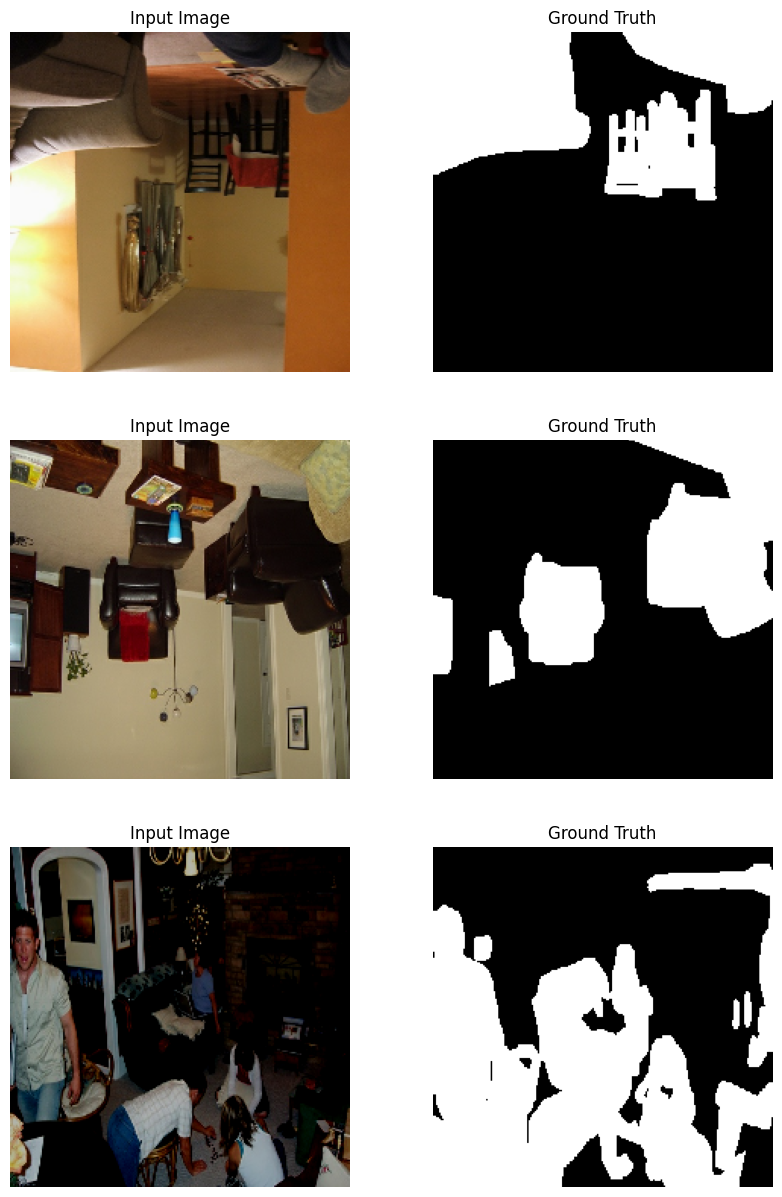

In [3]:
def load_voc2007_data(base_path):
    image_paths = []
    mask_paths = []
    for dirname, _, filenames in os.walk(os.path.join(base_path, 'JPEGImages')):
        for filename in filenames:
            if filename.endswith('.jpg'):
                image_paths.append(os.path.join(dirname, filename))
                mask_path = os.path.join(base_path, 'SegmentationClass', filename.replace('.jpg', '.png'))
                if os.path.exists(mask_path):
                    mask_paths.append(mask_path)
                else:
                    mask_paths.append(None)

    valid_image_paths = []
    valid_mask_paths = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        if mask_path:
            valid_image_paths.append(image_path)
            valid_mask_paths.append(mask_path)

    return valid_image_paths, valid_mask_paths

# 전처리 함수
def preprocess_image(image_path, mask_path, num_classes):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.uint8)

    # Ensure mask values are within the valid range [0, num_classes - 1]
    mask = tf.clip_by_value(mask, 0, num_classes - 1)

    return image, mask

# 데이터 증강 함수
def data_augmentation(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.3)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask

# 데이터셋 준비
base_path = '/content/drive/MyDrive/VOC2007'
image_paths, mask_paths = load_voc2007_data(base_path)
num_classes = 20  # VOC2007 데이터셋의 클래스 수 예시
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(lambda image, mask: preprocess_image(image, mask, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# 데이터셋 시각화 함수
def visualize_dataset(dataset):
    for images, masks in dataset.take(1):
        fig, axs = plt.subplots(3, 2, figsize=(10, 15))
        for i in range(3):
            axs[i, 0].imshow(images[i].numpy())
            axs[i, 0].set_title('Input Image')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(masks[i].numpy().squeeze(), cmap='gray')
            axs[i, 1].set_title('Ground Truth')
            axs[i, 1].axis('off')

        plt.show()

# 데이터셋 시각화
visualize_dataset(dataset)

In [5]:
# 모델 정의
def JHun_cnn(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv Block 1
    x = tf.keras.layers.Conv2D(512, (7, 7), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Conv Block 2
    x = tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='same')(pool1)
    x = tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='same')(x)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Conv Block 3
    x = tf.keras.layers.Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    x = tf.keras.layers.Conv2D(128, (7, 7), activation='relu', padding='same')(x)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Conv Block 4
    x = tf.keras.layers.Conv2D(64, (7, 7), activation='relu', padding='same')(pool3)
    x = tf.keras.layers.Conv2D(64, (7, 7), activation='relu', padding='same')(x)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Conv Block 5
    x = tf.keras.layers.Conv2D(32, (7, 7), activation='relu', padding='same')(pool4)
    x = tf.keras.layers.Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    pool5 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    return inputs, pool3, pool4, pool5

In [8]:
# FCN-8s 모델 정의
def fcn_8s_jhun(num_classes, input_shape=(224, 224, 3)):
    inputs, pool3, pool4, pool5 = JHun_cnn(input_shape)

    # 1x1 Convolution to preserve spatial information
    x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(pool5)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(x)

    # 2배 업샘플링과 pool4와의 스킵 연결
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    pool4 = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(pool4)
    x = tf.keras.layers.Add()([x, pool4])

    # 추가적인 2배 업샘플링과 pool3와의 스킵 연결
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    pool3 = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(pool3)
    x = tf.keras.layers.Add()([x, pool3])

    # 최종 업샘플링
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(16, 16), strides=(8, 8), padding='same')(x)

    # 각 픽셀의 클래스 확률을 얻기 위해 소프트맥스 사용
    outputs = tf.keras.layers.Softmax()(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

num_classes = 20  # VOC2007 데이터셋의 클래스 수 예시
model = fcn_8s_jhun(num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 224, 224, 512)        75776     ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 512)        0         ['conv2d_15[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 112, 112, 256)        6422784   ['max_pooling2d_5[0][0]'

In [9]:
model.fit(dataset, epochs=20)

Epoch 1/20
14/14 [==============================] - 242s 18s/step - loss: 2.2432 - accuracy: 0.4352
Epoch 2/20
14/14 [==============================] - 41s 3s/step - loss: 0.8636 - accuracy: 0.6107
Epoch 3/20
14/14 [==============================] - 41s 3s/step - loss: 0.7521 - accuracy: 0.6704
Epoch 4/20
14/14 [==============================] - 41s 3s/step - loss: 0.7110 - accuracy: 0.6754
Epoch 5/20
14/14 [==============================] - 42s 3s/step - loss: 0.6682 - accuracy: 0.6834
Epoch 6/20
14/14 [==============================] - 42s 3s/step - loss: 0.6527 - accuracy: 0.6898
Epoch 7/20
14/14 [==============================] - 42s 3s/step - loss: 0.6399 - accuracy: 0.6930
Epoch 8/20
14/14 [==============================] - 42s 3s/step - loss: 0.6321 - accuracy: 0.6959
Epoch 9/20
14/14 [==============================] - 42s 3s/step - loss: 0.6231 - accuracy: 0.6983
Epoch 10/20
14/14 [==============================] - 42s 3s/step - loss: 0.6175 - accuracy: 0.7024
Epoch 11/20
14/14

1/1 [==============================] - 0s 203ms/step


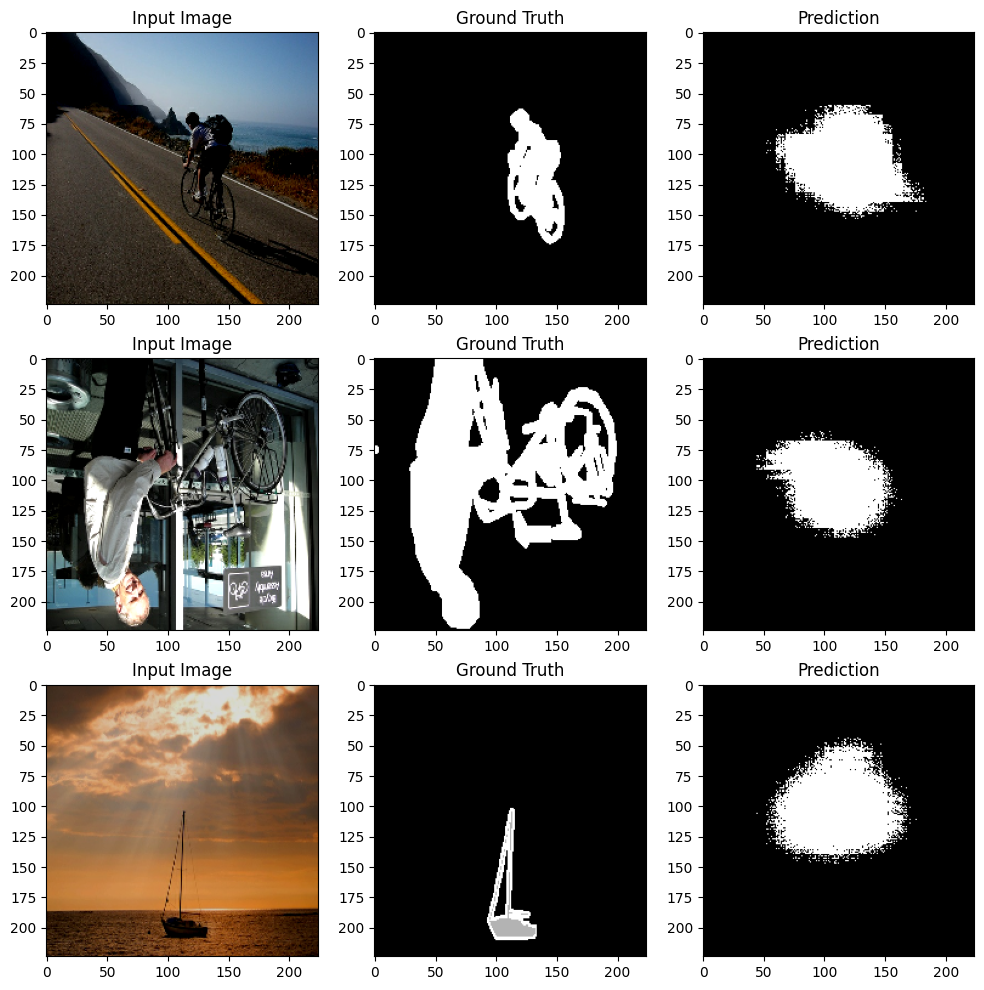

In [ ]:
def visualize_predictions(model, dataset):
    for images, masks in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)
        predictions = predictions[..., tf.newaxis]

        fig, axs = plt.subplots(3, 3, figsize=(12, 12))
        for i in range(3):
            axs[i, 0].imshow(images[i].numpy())
            axs[i, 0].set_title('Input Image')
            axs[i, 1].imshow(masks[i].numpy().squeeze(), cmap='gray')
            axs[i, 1].set_title('Ground Truth')
            axs[i, 2].imshow(predictions[i].numpy().squeeze(), cmap='gray')
            axs[i, 2].set_title('Prediction')

        plt.show()

visualize_predictions(model, dataset)